<img src="https://geodecode.com.br/wp-content/uploads/2021/12/brasildatacube.png" align="left" style="height: 65px"/>
<img src="https://earth.bsc.es/harmonize/lib/exe/fetch.php?h=250&crop=0&tok=cfb750&media=wiki:logo.png" align="right" style="height: 65px"/>

<h1 style="color:#336699; text-align: center">BDC Lab Demostration - 2024 Harmonize Annual Meeting</h1>
<h3 style="color:#336699; text-align: center">Compute monthly NDVI mean for each municipality</h3>
<hr style="border:2px solid #0077b9;">

<div style="text-align: center; font-size: 90%;">
    <a href="https://colab.research.google.com/github/Harmonize-Brazil/annual-meeting-bdclab-demo/" target = "_blank">
      <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Colab">
    </a>
    </br>
    </br>
    Luana Becker da Luz <a href="https://orcid.org/0000-0002-9916-1167"><i class="fab fa-orcid" aria-hidden="true" style="color: green"></i></a>,
    Ana Paula Dal'Asta <a href="https://orcid.org/0000-0002-1286-9067"><i class="fab fa-orcid" aria-hidden="true" style="color: green"></i></a>
    <br/>
    <br/>
    Earth Observation and Geoinformatics Division, National Institute for Space Research (INPE)
    <br/>
    Avenida dos Astronautas, 1758, Jardim da Granja, São José dos Campos, SP 12227-010, Brazil
    <br/><br/>
    Contact: 
    <a href="mailto:luana.luz@inpe.br">luana.luz@inpe.br;</a>
    <a href="mailto:ana.dalasta@inpe.br">ana.dalasta@inpe.br;</a>
    <a href="mailto:miguel.monteiro@inpe.br">miguel.monteiro@inpe.br</a>
    <br/>
    <br/>
    <div style="width: 60%; margin: auto">
        <div style="text-align: center; border-style: solid; border-color: #0077b9; border-width: 1px; padding: 10px;">
            This code uses sits R package to search for Sentinel 2 NDVI data on BDC STAC between start and end dates, aggregate data monthly, mosaic tiles of same month and compute municipality mean for each month in a single dataframe.
        </div>
    </div>
</div>

<h1 align="center">
  <img src="README_flowchart_roi.png" width="70%" style="text-align: center"/>
</h1>


In [1]:
library(dplyr)
library(sf)
library(sits)
library(stringr)

# 1. Set constants and ROI
<hr style="border:1px solid #0077b9;">

### 1.1 If BDC-Lab, set config.yaml

In [9]:
# If using BDC Lab, point to COIDS STAC
sits_config(config_user_file = "config.yaml")

### 1.2 Set constants

In [10]:
MULTICORES <- 2L

START_DATE <- "2019-01-01"
END_DATE <- "2019-12-31"

### 1.3 Get ROI and BBOX

In [11]:
# ROI_FILEPATH <- file.path("roi", "mun_indireto_PA.shp")
ROI_FILEPATH <- file.path("roi", "mocajuba.shp")

shape_sf <- st_read(ROI_FILEPATH)

shape_df <- shape_sf %>% as.data.frame()

dim(shape_df)
head(shape_df)

bbox <- st_bbox(shape_sf)
bbox

Reading layer `mocajuba' from data source 
  `/home/jovyan/workdir/annual_meeting_use_case/roi/mocajuba.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 5 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -49.75303 ymin: -2.68668 xmax: -49.20205 ymax: -2.413348
Geodetic CRS:  SIRGAS 2000


[1] 1 6

,CD_MUN,NM_MUN,SIGLA,AREA_KM2,cod,geometry
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<POLYGON [°]>
1,1504604,Mocajuba,PA,871.171,NA,POLYGON ((-49.20685 -2.4570...


      xmin       ymin       xmax       ymax 
-49.753027  -2.686680 -49.202052  -2.413348 

### 1.4 Create outputs folder

In [12]:
# Folder names
TMP_RASTERS_FOLDER <- "tmp"

# Create folder if not created
if (!file.exists(TMP_RASTERS_FOLDER)) {
  dir.create(TMP_RASTERS_FOLDER, recursive = TRUE)
  print(paste0(TMP_RASTERS_FOLDER, " folder created successfully."))
} else{
  print(paste0("Folder ", TMP_RASTERS_FOLDER, " already exists!"))
}

[1] "Folder tmp already exists!"


# 2. List SITS collections
<hr style="border:1px solid #0077b9;">

In [6]:
sits_list_collections()

BDC:
- CBERS-WFI-16D (CBERS-4/WFI)
- grid system: BDC-Large V2
- bands: NDVI EVI B13 B14 B15 B16 CLOUD
- opendata collection (requires access token)

- CBERS-WFI-8D (CBERS-4-4A/WFI)
- grid system: BDC-Large V2
- bands: NDVI EVI B13 B14 B15 B16 CLOUD
- opendata collection (requires access token)

- CBERS-MUX-2M (CBERS-4/MUX)
- grid system: BDC-Medium V2
- bands: NDVI EVI B05 B06 B07 B08 CLOUD
- opendata collection (requires access token)

- LANDSAT-OLI-16D (LANDSAT-8/OLI)
- grid system: BDC-Medium V1
- bands: NDVI EVI COASTAL BLUE GREEN RED NIR08 SWIR16 SWIR22 CLOUD
- opendata collection (requires access token)

- LANDSAT-2M (LANDSAT/TM-ETM-OLI)
- grid system: BDC-Medium V2
- bands: COASTAL BLUE GREEN RED NIR08 SWIR16 SWIR22 NDVI EVI CLOUD
- opendata collection (requires access token)

- MOD13Q1-6 (TERRA/MODIS)
- grid system: STG
- bands: NDVI EVI BLUE RED NIR MIR CLOUD
- opendata collection (requires access token)

- MYD13Q1-6 (AQUA/MODIS)
- grid system: STG
- bands: NDVI EVI BLUE RED 

# 3. Compute NDVI mean for each municipality
<hr style="border:1px solid #0077b9;">

<!-- ![Figure 2](https://raw.githubusercontent.com/e-sensing/sitsbook/master/images/data_cube_generation.png) -->

### 3.1 Set collection id

In [13]:
COLLECTION_ID <- "SENTINEL-2-16D"

### 3.2 Search images using sits_cube (get metadata)
- Using 2 CPUs, it took approximately 1 min to get 3 years of metadata
- Just for Mocajuba, 1 year, it took approximately 12s to get metadata

Warning message:
“object has no crs, assuming 'EPSG:4326'”


  |======================================================================| 100%
[1] "Execution time: 11.8612298965454 seconds"


[1] "2019-01-01" "2019-01-17" "2019-02-02" "2019-02-18" "2019-03-06"
 [6] "2019-03-22" "2019-04-07" "2019-04-23" "2019-05-09" "2019-05-25"
[11] "2019-06-10" "2019-06-26" "2019-07-12" "2019-07-28" "2019-08-13"
[16] "2019-08-29" "2019-09-14" "2019-09-30" "2019-10-16" "2019-11-01"
[21] "2019-11-17" "2019-12-03" "2019-12-19"

# A tibble: 46 × 14
   fid      date       band   xres  yres   xmin   ymin   xmax   ymax nrows ncols
   <chr>    <date>     <chr> <dbl> <dbl>  <dbl>  <dbl>  <dbl>  <dbl> <dbl> <dbl>
 1 S2-16D_… 2019-01-01 CLOUD    10    10 5.37e6 1.10e7 5.48e6 1.11e7 10560 10560
 2 S2-16D_… 2019-01-01 NDVI     10    10 5.37e6 1.10e7 5.48e6 1.11e7 10560 10560
 3 S2-16D_… 2019-01-17 CLOUD    10    10 5.37e6 1.10e7 5.48e6 1.11e7 10560 10560
 4 S2-16D_… 2019-01-17 NDVI     10    10 5.37e6 1.10e7 5.48e6 1.11e7 10560 10560
 5 S2-16D_… 2019-02-02 CLOUD    10    10 5.37e6 1.10e7 5.48e6 1.11e7 10560 10560
 6 S2-16D_… 2019-02-02 NDVI     10    10 5.37e6 1.10e7 5.48e6 1.11e7 10560 10560
 7 S2-16D_… 2019-02-18 CLOUD    10    10 5.37e6 1.10e7 5.48e6 1.11e7 10560 10560
 8 S2-16D_… 2019-02-18 NDVI     10    10 5.37e6 1.10e7 5.48e6 1.11e7 10560 10560
 9 S2-16D_… 2019-03-06 CLOUD    10    10 5.37e6 1.10e7 5.48e6 1.11e7 10560 10560
10 S2-16D_… 2019-03-06 NDVI     10    10 5.37e6 1.10e7 5.48e6 1.11e7 10560 10560
# ℹ 36 m

plotting false color image



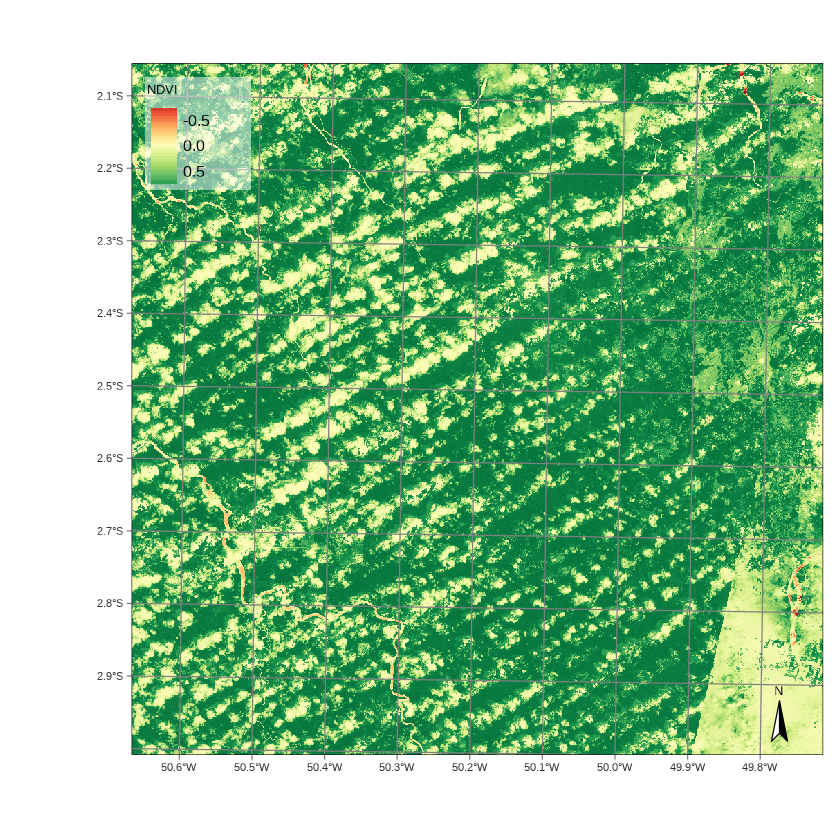

In [14]:
# Obtain metadata
st <- Sys.time()
s2_cube <- sits_cube(
  source = "BDC",
  collection = COLLECTION_ID,
  bands = c("NDVI", "CLOUD"),
  roi = bbox,
  start_date = START_DATE,
  end_date = END_DATE,
  progress = TRUE
)
proc_time_s <- difftime(Sys.time(), st, units = "secs")
print(paste0("Execution time: ", proc_time_s, " seconds"))

sits_timeline(s2_cube)
print(s2_cube$file_info[[1]])
plot(s2_cube, band = "NDVI", time = 1)

### 3.3 (If not using BDC-Lab) Download all images loccaly
- For 21 municipalities covering 24 tiles, 3 years of data, bands "NDVI","CLOUD", it has approximately 350 GB of data

In [7]:
st <- Sys.time()
s2_cube <- sits_cube_copy(
  cube = s2_cube,
  output_dir = TMP_RASTERS_FOLDER,
  multicores = MULTICORES
)
proc_time_s <- difftime(Sys.time(), st, units = "secs")
print(paste0("Execution time: ", proc_time_s, " seconds"))

head(t(s2_cube))

  |=                                                                     |   1%

### 3.4 Aggregate all tiles of same month in one
- Using 2 cores, it took approximately 518s to aggregate monthly 12 months for 21 municipalities (res = 250m)
- Just for Mocajuba, 1 year of data, it took approximately 47s to monthly aggregate all images of same tile/month

**NOTE: Use period="P7D" if you wish to aggregate data weekly**

Warning message:
“Regularization works better when data store locally. Please, use 'sits_cube_copy()' to copy data locally before regularization”


  |======================================================================| 100%
[1] "Execution time: 45.4184858798981 seconds"


[1] "2019-01-01" "2019-02-01" "2019-03-01" "2019-04-01" "2019-05-01"
 [6] "2019-06-01" "2019-07-01" "2019-08-01" "2019-09-01" "2019-10-01"
[11] "2019-11-01" "2019-12-01"

plotting false color image



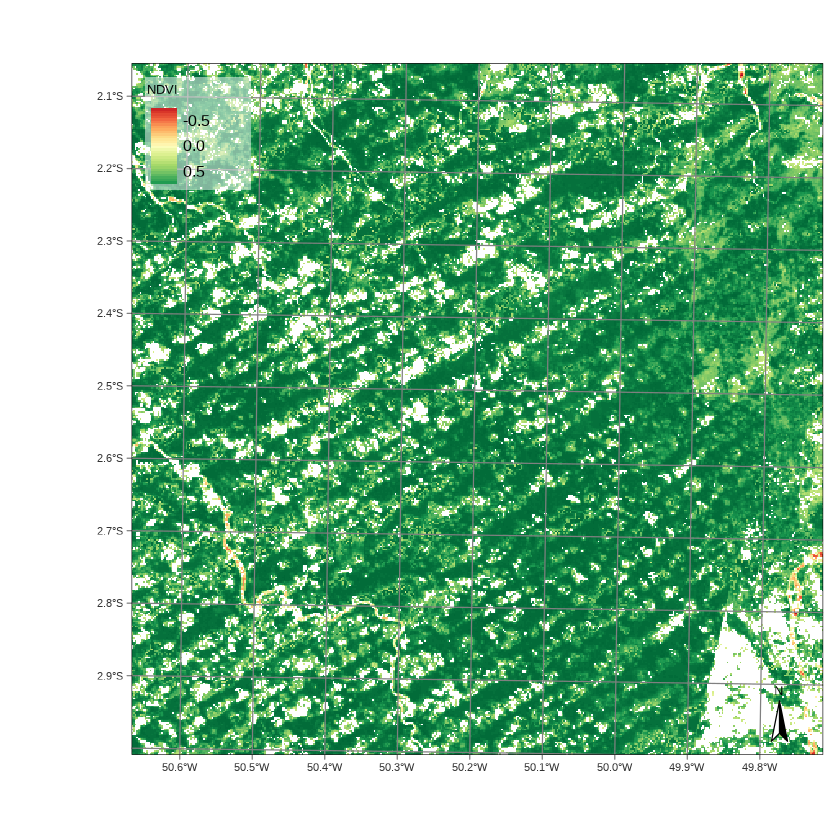

In [15]:
st <- Sys.time()
s2_regular_cube <- sits_regularize(
  s2_cube,
  res = 250,
  output_dir = TMP_RASTERS_FOLDER,
  period = "P1M",
  multicores = MULTICORES
)
proc_time_s <- difftime(Sys.time(), st, units = "secs")
print(paste0("Execution time: ", proc_time_s, " seconds"))

sits_timeline(s2_regular_cube)
plot(s2_regular_cube, band = "NDVI", time = 1)

### 3.5 Mosaic all montly aggregated tiles by month
- Using 2 cores, it took approximately 80s to mosaic 12 monthly images (+- 7s per mosaic), using 21 municipalities and spatial resolution of 250m.
- Just for Mocajuba, 1 year of data, it took approximately 16s to mosaic all tiles of same month

Warning message:
“object has no crs, assuming 'EPSG:4326'”


  |======================================================================| 100%
  |======================================================================| 100%
[1] "Execution time: 13.9165630340576 seconds"


plotting false color image



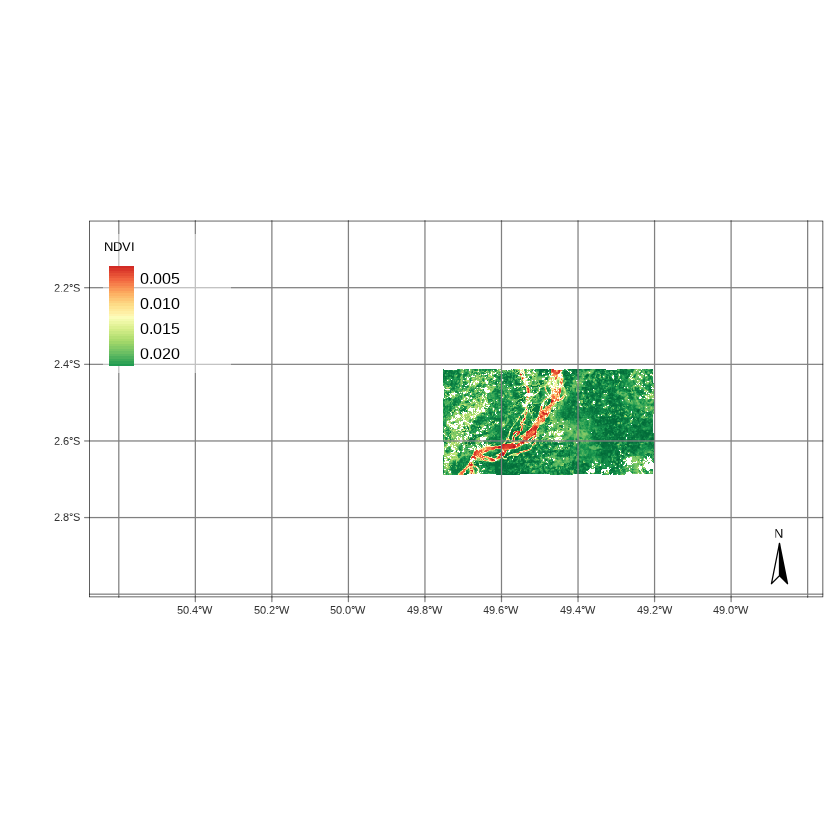

In [16]:
st <- Sys.time()
mosaic_cube <- sits_mosaic(
  cube = s2_regular_cube,
  roi = bbox,
  crs = "EPSG:4326",
  output_dir = TMP_RASTERS_FOLDER,
  progress = TRUE,
  multicores = MULTICORES
)
proc_time_s <- difftime(Sys.time(), st, units = "secs")
print(paste0("Execution time: ", proc_time_s, " seconds"))

plot(mosaic_cube, band = "NDVI", time = 1)

### 3.6 For each computed mosaic, extract mean for each municipality
- It took approximately 50s to extract 21 municipalities ndvi mean for each mosaic
- Just for Mocajuba, 1 year of data, it took approximately 12s in total to extract municipality mean for each month

In [17]:
mosaic_filepaths <- list.files(TMP_RASTERS_FOLDER, full.names = TRUE, pattern = "*MOSAIC.*\\.tif")
mosaic_filepaths

[1] "tmp/SENTINEL-2_MSI_MOSAIC_2019-01-01_2019-01-01_NDVI_v1.tif"
 [2] "tmp/SENTINEL-2_MSI_MOSAIC_2019-02-01_2019-02-01_NDVI_v1.tif"
 [3] "tmp/SENTINEL-2_MSI_MOSAIC_2019-03-01_2019-03-01_NDVI_v1.tif"
 [4] "tmp/SENTINEL-2_MSI_MOSAIC_2019-04-01_2019-04-01_NDVI_v1.tif"
 [5] "tmp/SENTINEL-2_MSI_MOSAIC_2019-05-01_2019-05-01_NDVI_v1.tif"
 [6] "tmp/SENTINEL-2_MSI_MOSAIC_2019-06-01_2019-06-01_NDVI_v1.tif"
 [7] "tmp/SENTINEL-2_MSI_MOSAIC_2019-07-01_2019-07-01_NDVI_v1.tif"
 [8] "tmp/SENTINEL-2_MSI_MOSAIC_2019-08-01_2019-08-01_NDVI_v1.tif"
 [9] "tmp/SENTINEL-2_MSI_MOSAIC_2019-09-01_2019-09-01_NDVI_v1.tif"
[10] "tmp/SENTINEL-2_MSI_MOSAIC_2019-10-01_2019-10-01_NDVI_v1.tif"
[11] "tmp/SENTINEL-2_MSI_MOSAIC_2019-11-01_2019-11-01_NDVI_v1.tif"
[12] "tmp/SENTINEL-2_MSI_MOSAIC_2019-12-01_2019-12-01_NDVI_v1.tif"

In [27]:
extract_ndvi_to_csv <- function(tif_filepath) {
  st <- Sys.time()

  # Create csv output filename from filepath (remove ".tif" and dirname)
  tif_id <- gsub("\\.tif$", "", basename(tif_filepath))
  csv_output_filepath <- file.path(TMP_RASTERS_FOLDER, paste0(tif_id, ".csv"))

  # Open raster, extract mean ndvi based on ROI and save csv
  r <- raster::raster(tif_filepath)
  extracted_values <- raster::extract(r, shape_sf, fun = mean, df = TRUE, na.rm = TRUE)
  write.csv(extracted_values, csv_output_filepath, row.names = FALSE)

  # TODO: When using this function, some rasters may not intersect with shape

  # Print processing time
  proc_time_s <- difftime(Sys.time(), st, units = "secs")
  print(paste("It took ", proc_time_s, " s to extract ", csv_output_filepath))
}

# For each filepath, run function
lapply(mosaic_filepaths, extract_ndvi_to_csv) 

[1] "It took  44.6751754283905  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-01-01_2019-01-01_NDVI_v1.csv"
[1] "It took  43.8175964355469  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-02-01_2019-02-01_NDVI_v1.csv"
[1] "It took  43.8638508319855  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-03-01_2019-03-01_NDVI_v1.csv"
[1] "It took  269.192006349564  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-04-01_2019-04-01_NDVI_v1.csv"
[1] "It took  215.863662481308  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-05-01_2019-05-01_NDVI_v1.csv"
[1] "It took  211.894786119461  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-06-01_2019-06-01_NDVI_v1.csv"
[1] "It took  199.710391283035  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-07-01_2019-07-01_NDVI_v1.csv"
[1] "I

[[1]]
[1] "It took  44.6751754283905  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-01-01_2019-01-01_NDVI_v1.csv"

[[2]]
[1] "It took  43.8175964355469  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-02-01_2019-02-01_NDVI_v1.csv"

[[3]]
[1] "It took  43.8638508319855  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-03-01_2019-03-01_NDVI_v1.csv"

[[4]]
[1] "It took  269.192006349564  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-04-01_2019-04-01_NDVI_v1.csv"

[[5]]
[1] "It took  215.863662481308  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-05-01_2019-05-01_NDVI_v1.csv"

[[6]]
[1] "It took  211.894786119461  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-06-01_2019-06-01_NDVI_v1.csv"

[[7]]
[1] "It took  199.710391283035  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-07-01_2019-07-01_NDVI_v1.csv"

[[8]]
[1] "It took  202.354318857193  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-08-01_2019-08-01_NDVI_v1.csv"

[[9]]
[1] "It took  207.558956623077  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-09-01_2019-09-01_NDVI_v1.csv"

[[10]]
[1] "It took  206.826120615005  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-10-01_2019-10-01_NDVI_v1.csv"

[[11]]
[1] "It took  204.205665588379  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-11-01_2019-11-01_NDVI_v1.csv"

[[12]]
[1] "It took  203.399286031723  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-12-01_2019-12-01_NDVI_v1.csv"

[[13]]
[1] "It took  202.009108781815  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2020-01-01_2020-01-01_NDVI_v1.csv"

[[14]]
[1] "It took  204.001042604446  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2020-02-01_2020-02-01_NDVI_v1.csv"

[[15]]
[1] "It took  207.27379655838  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2020-03-01_2020-03-01_NDVI_v1.csv"

[[16]]
[1] "It took  202.511696338654  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2020-04-01_2020-04-01_NDVI_v1.csv"

[[17]]
[1] "It took  202.519921302795  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2020-05-01_2020-05-01_NDVI_v1.csv"

[[18]]
[1] "It took  39.336457490921  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2020-06-01_2020-06-01_NDVI_v1.csv"

[[19]]
[1] "It took  39.7198891639709  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2020-07-01_2020-07-01_NDVI_v1.csv"

[[20]]
[1] "It took  39.3007581233978  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2020-08-01_2020-08-01_NDVI_v1.csv"

[[21]]
[1] "It took  40.2714848518372  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2020-09-01_2020-09-01_NDVI_v1.csv"

[[22]]
[1] "It took  39.7700855731964  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2020-10-01_2020-10-01_NDVI_v1.csv"

[[23]]
[1] "It took  40.3085136413574  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2020-11-01_2020-11-01_NDVI_v1.csv"

[[24]]
[1] "It took  39.7539498806  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2020-12-01_2020-12-01_NDVI_v1.csv"

[[25]]
[1] "It took  43.9688012599945  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2021-01-01_2021-01-01_NDVI_v1.csv"

[[26]]
[1] "It took  42.0802824497223  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2021-02-01_2021-02-01_NDVI_v1.csv"

[[27]]
[1] "It took  42.6485188007355  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_

### 3.7 Open each monthly ndvi mean municipalities csvs, merge with original shapefile, then rbind all 
- Just for Mocajuba, 1 year of data, it took approximately 1s in total to merge all NDVI csvs

In [2]:
mosaic_csvs_filepaths <- list.files(TMP_RASTERS_FOLDER, full.names = TRUE, pattern = "*.csv")
mosaic_csvs_filepaths

ERROR: Error in list.files(TMP_RASTERS_FOLDER, full.names = TRUE, pattern = "*MOSAIC*"): object 'TMP_RASTERS_FOLDER' not found


In [29]:
pixels_ndvi_to_feature_mean <- function(csv_filepath){
  st <- Sys.time()

  # Get csv filename
  csv_filename <- basename(csv_filepath)
  
  # Open ROI shape, select just CD_MUN and create the ID
  shape_with_id <- shape_df %>%
    select(CD_MUN) %>%
    mutate(ID = as.integer(rownames(shape_df)))

  # Open ndvi csv, merge with roi and apply ndvi scale
  merge_mean_with_shape <- read.csv(csv_filepath) %>%
    merge(shape_with_id, by = "ID") %>%
    rename(cd_mun = CD_MUN, ndvi = NDVI) %>%
    mutate(ndvi = ndvi * 0.0001) %>%
    # Extrat year month from csv filename
    mutate(year_month = str_extract(csv_filename, "\\d{4}-\\d{2}")) %>%
    select(cd_mun, year_month, ndvi)

  # Print processing time
  proc_time_s <- difftime(Sys.time(), st, units = "secs")
  print(paste0("Execution time: ", proc_time_s, " seconds"))

  return(merge_mean_with_shape)
}

# For each csv filepath, open csv , merge with original shapefile and set year_month
list_ndvi_means <- lapply(mosaic_csvs_filepaths, pixels_ndvi_to_feature_mean)

# Bind all dataframes in one big dataframe
df_ndvi_means <- do.call(rbind, list_ndvi_means)

dim(df_ndvi_means)
head(df_ndvi_means, 30)

[1] "Execution time: 0.0238888263702393 seconds"
[1] "Execution time: 0.0182271003723145 seconds"
[1] "Execution time: 0.0185632705688477 seconds"
[1] "Execution time: 0.0188314914703369 seconds"
[1] "Execution time: 0.020925760269165 seconds"
[1] "Execution time: 0.0240592956542969 seconds"
[1] "Execution time: 0.0201146602630615 seconds"
[1] "Execution time: 0.0224020481109619 seconds"
[1] "Execution time: 0.0233860015869141 seconds"
[1] "Execution time: 0.0180830955505371 seconds"
[1] "Execution time: 0.0179193019866943 seconds"
[1] "Execution time: 0.0173211097717285 seconds"
[1] "Execution time: 0.017690896987915 seconds"
[1] "Execution time: 0.018186092376709 seconds"
[1] "Execution time: 0.0179798603057861 seconds"
[1] "Execution time: 0.0176286697387695 seconds"
[1] "Execution time: 0.017869234085083 seconds"
[1] "Execution time: 0.0176563262939453 seconds"
[1] "Execution time: 0.0176687240600586 seconds"
[1] "Execution time: 0.0179193019866943 seconds"
[1] "Execution time: 0.0

[1] 756   3

,CD_MUN,year_month,mean_NDVI
,<chr>,<chr>,<dbl>
1,1500107,2019-01,0.01830809
2,1500800,2019-01,0.01879105
3,1501105,2019-01,0.02110660
4,1501204,2019-01,0.02033529
5,1501303,2019-01,0.01650262
6,1501402,2019-01,0.01403199
7,1501501,2019-01,0.02026479
8,1501782,2019-01,0.02007037
9,1502103,2019-01,0.01913963


### 3.8 Save NDVI data

In [31]:
FINAL_CSV_NAME <- "csvs/data_ndvi_months_2019.csv"

write.csv(df_ndvi_means, FINAL_CSV_NAME, row.names = FALSE)